In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os

from arch import arch_model
from sklearn.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA


## Data Import

In [3]:
# Define the 5 stock tickers (can be randomized later on)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

stock_data = {}

for ticker in tickers:
    csv_filepath = f"data/{ticker}.csv"  
    try:
        df = pd.read_csv(csv_filepath, index_col="Date", parse_dates=True)
        print(f"Data loaded successfully from {csv_filepath}")
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_filepath}. Downloading data from Yahoo Finance...")
        stock = yf.Ticker(ticker)
        hist = stock.history(start="2010-01-01", end="2025-03-07")
        df = pd.DataFrame(hist, columns=["Close"])
        df.to_csv(csv_filepath)
        print(f"Data for {ticker} downloaded and saved to {csv_filepath}")
    # Keep only the Close price
    df.rename(columns={"Close": ticker}, inplace=True)
    stock_data[ticker] = df[[ticker]]  


df_combined = pd.concat(stock_data.values(), axis=1)
df_combined.dropna(inplace=True)

print(df_combined.head())


Data loaded successfully from data/AAPL.csv
Data loaded successfully from data/MSFT.csv
Data loaded successfully from data/GOOGL.csv
Data loaded successfully from data/AMZN.csv
Data loaded successfully from data/TSLA.csv
                               AAPL       MSFT      GOOGL    AMZN      TSLA
Date                                                                       
2010-06-29 00:00:00-04:00  7.709079  17.675097  11.326808  5.4305  1.592667
2010-06-30 00:00:00-04:00  7.569441  17.447613  11.094666  5.4630  1.588667
2010-07-01 00:00:00-04:00  7.477657  17.561352  10.958523  5.5480  1.464000
2010-07-02 00:00:00-04:00  7.431316  17.644762  10.885215  5.4570  1.280000
2010-07-06 00:00:00-04:00  7.482172  18.061806  10.873248  5.5030  1.074000


## Exploratory Data Analysis

In [4]:
returns = np.log(df_combined / df_combined.shift(1)) * 100  # Multiply by 100 to express in percentage
returns.dropna(inplace=True) 

print(returns.head())

                               AAPL      MSFT     GOOGL      AMZN       TSLA
Date                                                                        
2010-06-30 00:00:00-04:00 -1.827944 -1.295384 -2.070789  0.596684  -0.251464
2010-07-01 00:00:00-04:00 -1.219971  0.649773 -1.234692  1.543942  -8.172292
2010-07-02 00:00:00-04:00 -0.621660  0.473841 -0.671206 -1.653833 -13.431235
2010-07-06 00:00:00-04:00  0.682024  2.336056 -0.109996  0.839421 -17.547006
2010-07-07 00:00:00-04:00  3.958715  1.995069  3.188897  3.016031  -1.943053


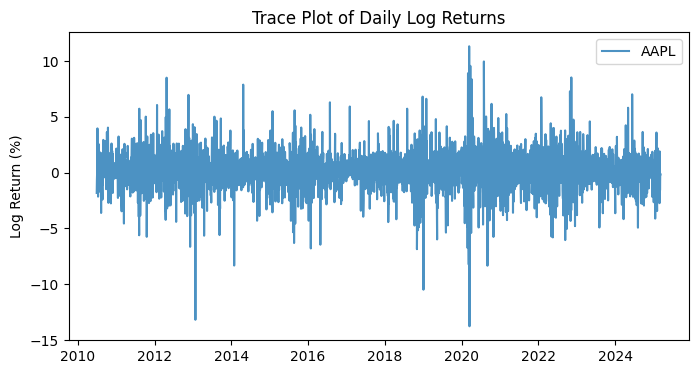

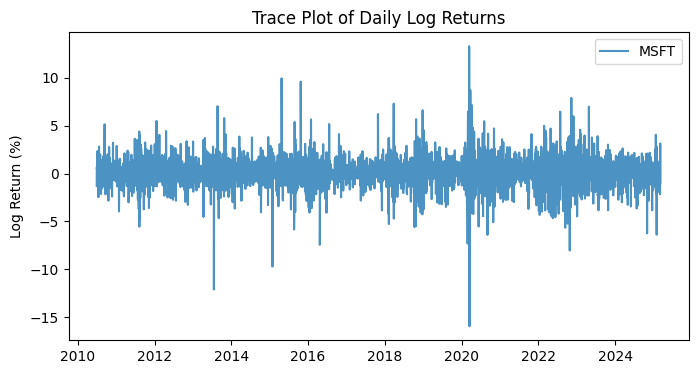

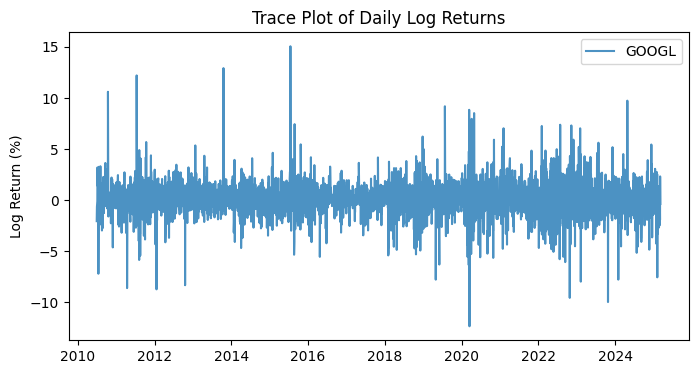

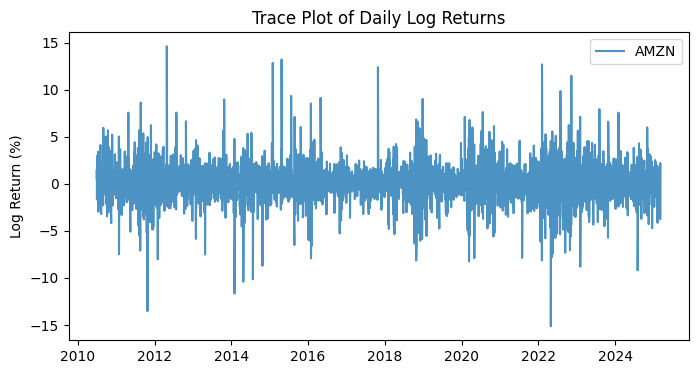

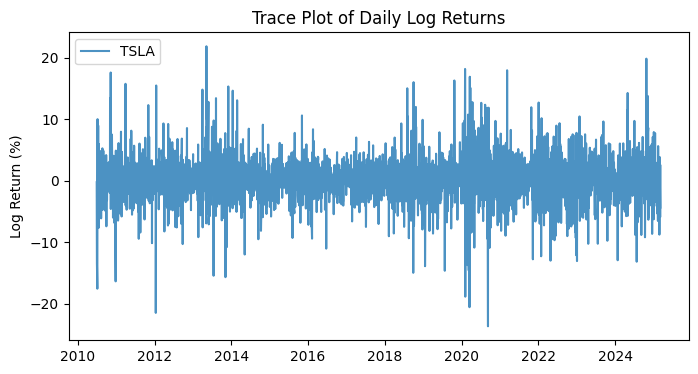

In [5]:
for ticker in returns.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(returns.index, returns[ticker], label=ticker, alpha=0.8)
    plt.title("Trace Plot of Daily Log Returns")
    plt.ylabel("Log Return (%)")
    plt.legend()
    plt.show()


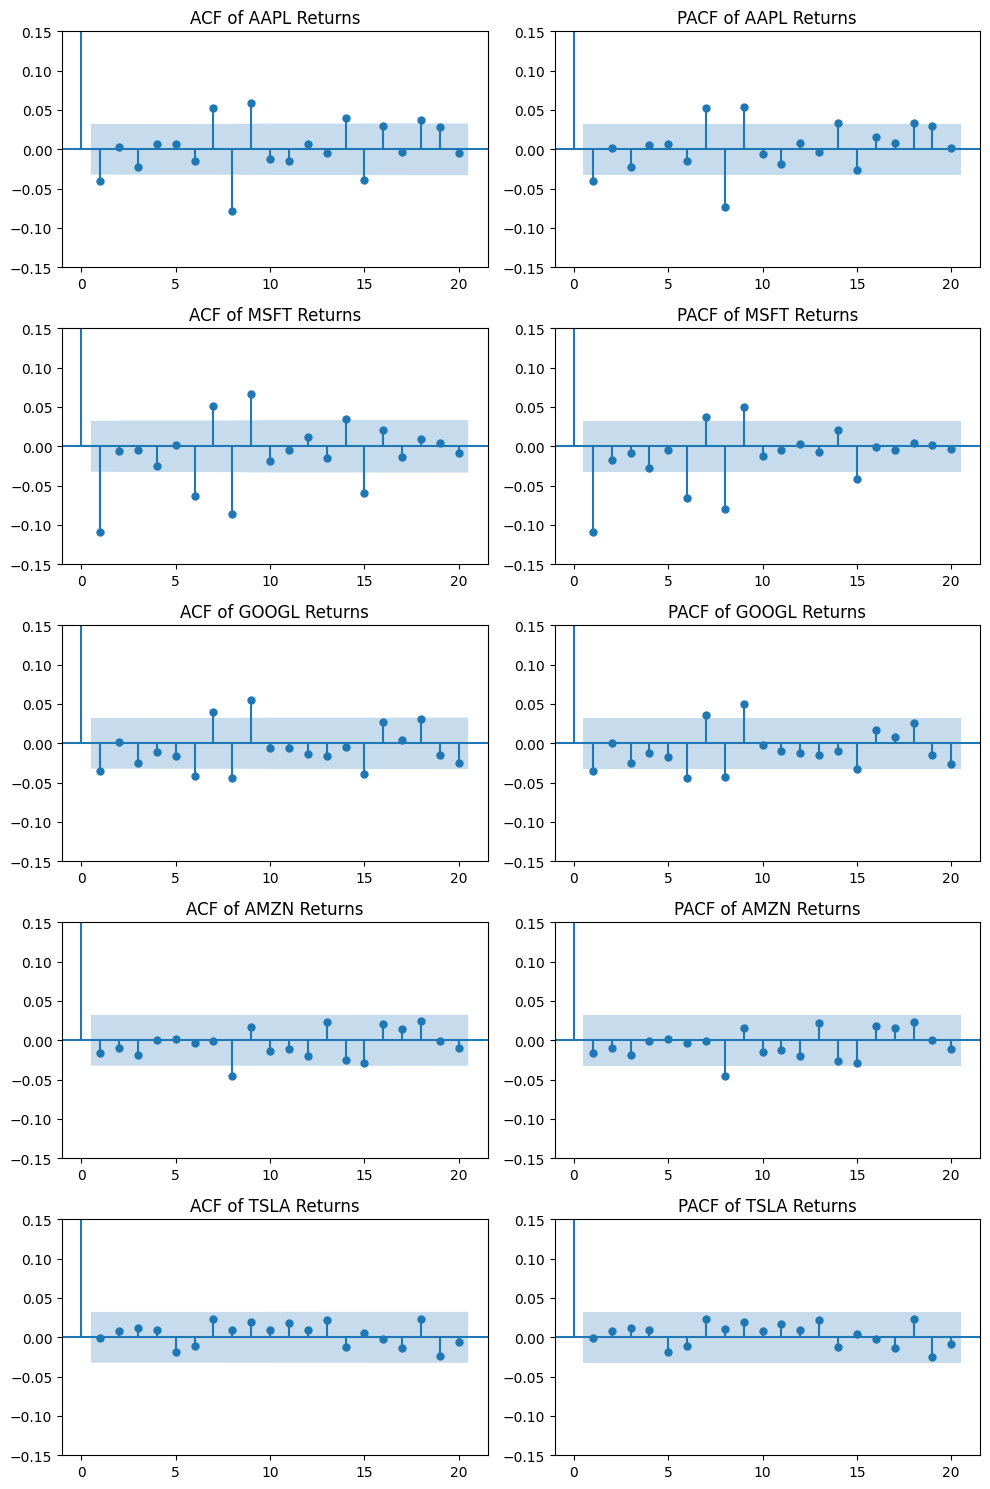

In [13]:
fig, axes = plt.subplots(len(returns.columns), 2, figsize=(10, len(returns.columns) * 3))

for i, ticker in enumerate(returns.columns):
    plot_acf(returns[ticker], ax=axes[i, 0], lags=20, title=f"ACF of {ticker} Returns")
    axes[i, 0].set_ylim(-0.15, 0.15)
    plot_pacf(returns[ticker], ax=axes[i, 1], lags=20, title=f"PACF of {ticker} Returns")
    axes[i, 1].set_ylim(-0.15, 0.15)

plt.tight_layout()
plt.show()

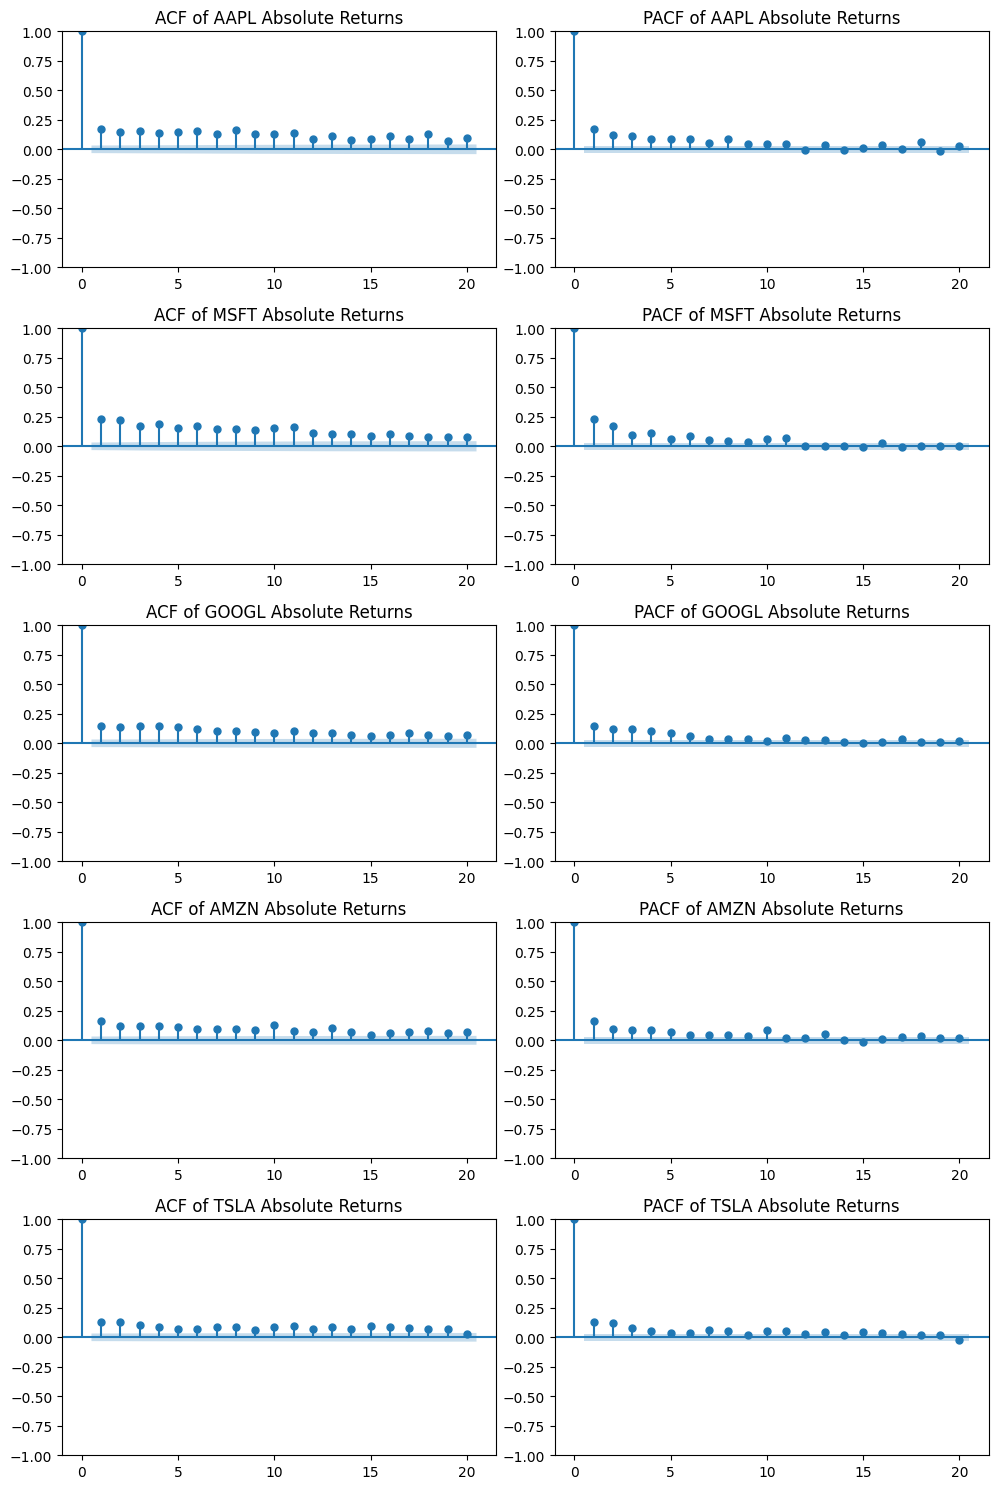

In [ ]:
abs_returns = returns.abs().dropna()

fig, axes = plt.subplots(len(abs_returns.columns), 2, figsize=(10, len(abs_returns.columns) * 3))

for i, ticker in enumerate(abs_returns.columns):
    plot_acf(abs_returns[ticker], ax=axes[i, 0], lags=25, title=f"ACF of {ticker} Absolute Returns")
    plot_pacf(abs_returns[ticker], ax=axes[i, 1], lags=25, title=f"PACF of {ticker} Absolute Returns")

plt.tight_layout()
plt.show()

How to interpret: If the values in the ACF gradually decrease but stay significant, we have significant autocorrelation. This indicates volatility clustering, confirming the need for GARCH models.

## Forecasting Volatility

In [8]:
# Reshape returns dataset into a long format
returns_long = returns.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Return')
print(returns_long.head())

returns_long = returns_long.sort_values(["Date", "Ticker"])

train_size = int(len(returns_long) * 0.8)
train_data = returns_long[:train_size]
test_data = returns_long[train_size:]

                        Date Ticker    Return
0  2010-06-30 00:00:00-04:00   AAPL -1.827944
1  2010-07-01 00:00:00-04:00   AAPL -1.219971
2  2010-07-02 00:00:00-04:00   AAPL -0.621660
3  2010-07-06 00:00:00-04:00   AAPL  0.682024
4  2010-07-07 00:00:00-04:00   AAPL  3.958715


### GARCH (1,1)

In [ ]:
garch_forecast_results = {}

for ticker in tickers:
    print(f"\nTraining GARCH(1,1) model for {ticker}...\n")
    
    train_size = int(len(returns) * 0.8)
    y_train = returns[ticker].iloc[:train_size].dropna()
    y_test = returns[ticker].iloc[train_size:].dropna()
    
    garch_mod = arch_model(y_train, mean="Zero", vol="Garch", p=20, q=20, rescale=False)
    res_garch = garch_mod.fit(disp="off")  
    print(res_garch.summary())

    # **N-Step Ahead Forecast**
    yhat = res_garch.forecast(horizon=len(y_test), reindex=True)
    
    garch_forecast_results[ticker] = {
        "train_data": y_train,
        "test_data": y_test,
        "model": res_garch,
        "n_step_forecast": np.sqrt(yhat.variance.values[-1, :])  # Convert variance to volatility
    }

### **One-Step Ahead Rolling Forecast**
rolling_preds = {}

for ticker in tickers:
    print(f"\nGenerating rolling volatility forecasts for {ticker}...")
    
    y_test = garch_forecast_results[ticker]["test_data"]
    rolling_preds[ticker] = []
    
    for i in range(len(y_test)): 
        train = returns[ticker].iloc[:train_size + i].dropna()  # Dynamically expanding training set
        
        # Fit new GARCH model
        model = arch_model(train, mean="Zero", vol="Garch", p=1, q=1, rescale=False)
        model_fit = model.fit(disp="off")
        
        pred = model_fit.forecast(horizon=1, reindex=True)
        rolling_preds[ticker].append(np.sqrt(pred.variance.values[-1, 0]))


    rolling_preds[ticker] = pd.Series(rolling_preds[ticker], index=y_test.index)


### **Compare N-Step and Rolling Predictions**
fig, axes = plt.subplots(len(tickers), 2, figsize=(12, len(tickers) * 3), sharex=True)

for i, ticker in enumerate(tickers):
    ax1, ax2 = axes[i]
    
    y_test = garch_forecast_results[ticker]["test_data"]
    n_step_volatility = garch_forecast_results[ticker]["n_step_forecast"]
    rolling_volatility = rolling_preds[ticker]

    # Plot N-Step Predictions
    ax1.plot(y_test.index, y_test.values, label="Actual Returns", alpha=0.6)
    ax1.plot(y_test.index, n_step_volatility, label="N-Step Ahead Volatility", linestyle="--", alpha=0.8)
    ax1.set_title(f"{ticker} - N-Step Ahead GARCH(1,1) Predictions")
    ax1.legend()

    # Plot Rolling Predictions
    ax2.plot(y_test.index, y_test.values, label="Actual Returns", alpha=0.6)
    ax2.plot(y_test.index, rolling_volatility, label="Rolling Forecast", linestyle="--", alpha=0.8)
    ax2.set_title(f"{ticker} - Rolling Forecast GARCH(1,1)")
    ax2.legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


Training GARCH(1,1) model for AAPL...

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5621.96
Distribution:                  Normal   AIC:                           11325.9
Method:            Maximum Likelihood   BIC:                           11571.6
                                        No. Observations:                 2955
Date:                Tue, Mar 18 2025   Df Residuals:                     2955
Time:                        15:42:09   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.1064      2.8

KeyboardInterrupt: 

### EGARCH(1,1)


Training EGARCH(1,1) model for AAPL with p=q=1...


Training EGARCH(1,1) model for MSFT with p=q=1...


Training EGARCH(1,1) model for GOOGL with p=q=1...


Training EGARCH(1,1) model for AMZN with p=q=1...


Training EGARCH(1,1) model for TSLA with p=q=1...


Training EGARCH(1,1) model for AAPL with p=q=2...


Training EGARCH(1,1) model for MSFT with p=q=2...


Training EGARCH(1,1) model for GOOGL with p=q=2...


Training EGARCH(1,1) model for AMZN with p=q=2...


Training EGARCH(1,1) model for TSLA with p=q=2...


Training EGARCH(1,1) model for AAPL with p=q=3...


Training EGARCH(1,1) model for MSFT with p=q=3...


Training EGARCH(1,1) model for GOOGL with p=q=3...


Training EGARCH(1,1) model for AMZN with p=q=3...


Training EGARCH(1,1) model for TSLA with p=q=3...


Training EGARCH(1,1) model for AAPL with p=q=4...


Training EGARCH(1,1) model for MSFT with p=q=4...


Training EGARCH(1,1) model for GOOGL with p=q=4...


Training EGARCH(1,1) model for AMZN with p=q=4...


Trainin

/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for MSFT with p=q=23...


Training EGARCH(1,1) model for GOOGL with p=q=23...


Training EGARCH(1,1) model for AMZN with p=q=23...


Training EGARCH(1,1) model for TSLA with p=q=23...


Training EGARCH(1,1) model for AAPL with p=q=24...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for MSFT with p=q=24...


Training EGARCH(1,1) model for GOOGL with p=q=24...


Training EGARCH(1,1) model for AMZN with p=q=24...


Training EGARCH(1,1) model for TSLA with p=q=24...


Training EGARCH(1,1) model for AAPL with p=q=25...


Training EGARCH(1,1) model for MSFT with p=q=25...


Training EGARCH(1,1) model for GOOGL with p=q=25...


Training EGARCH(1,1) model for AMZN with p=q=25...


Training EGARCH(1,1) model for TSLA with p=q=25...


Training EGARCH(1,1) model for AAPL with p=q=26...


Training EGARCH(1,1) model for MSFT with p=q=26...


Training EGARCH(1,1) model for GOOGL with p=q=26...


Training EGARCH(1,1) model for AMZN with p=q=26...


Training EGARCH(1,1) model for TSLA with p=q=26...


Training EGARCH(1,1) model for AAPL with p=q=27...


Training EGARCH(1,1) model for MSFT with p=q=27...


Training EGARCH(1,1) model for GOOGL with p=q=27...


Training EGARCH(1,1) model for AMZN with p=q=27...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for TSLA with p=q=27...


Training EGARCH(1,1) model for AAPL with p=q=28...


Training EGARCH(1,1) model for MSFT with p=q=28...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for GOOGL with p=q=28...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for AMZN with p=q=28...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for TSLA with p=q=28...


Training EGARCH(1,1) model for AAPL with p=q=29...


Training EGARCH(1,1) model for MSFT with p=q=29...


Training EGARCH(1,1) model for GOOGL with p=q=29...


Training EGARCH(1,1) model for AMZN with p=q=29...


Training EGARCH(1,1) model for TSLA with p=q=29...


Training EGARCH(1,1) model for AAPL with p=q=30...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for MSFT with p=q=30...


Training EGARCH(1,1) model for GOOGL with p=q=30...



/home/adrian/tio4317-time-series-project/.venv/lib/python3.11/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Training EGARCH(1,1) model for AMZN with p=q=30...


Training EGARCH(1,1) model for TSLA with p=q=30...



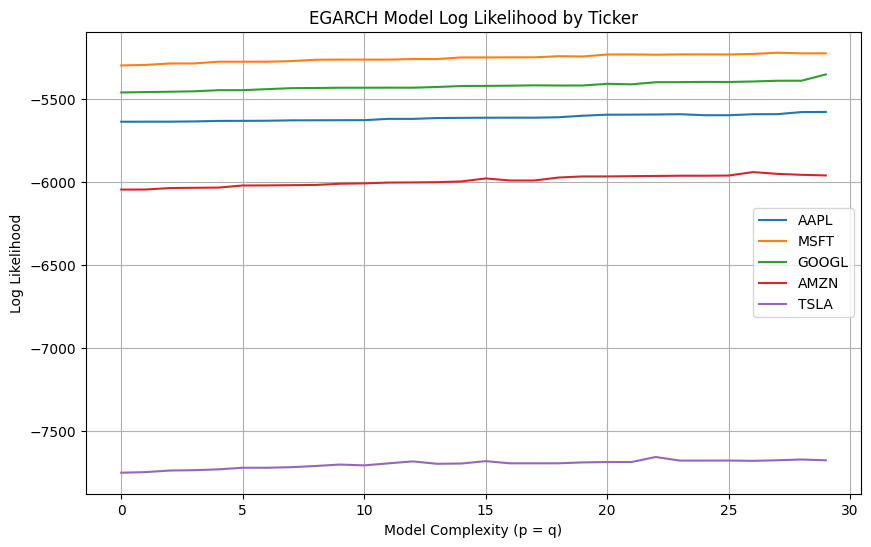

In [19]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store log likelihoods for each ticker
egarch_forecast_results = {ticker: [] for ticker in tickers}

for x in range(1, 31):
    for ticker in tickers:
        print(f"\nTraining EGARCH(1,1) model for {ticker} with p=q={x}...\n")
        
        train_size = int(len(returns) * 0.8)
        y_train = returns[ticker].iloc[:train_size].dropna()
        y_test = returns[ticker].iloc[train_size:].dropna()
        
        egarch_mod = arch_model(y_train, mean="Zero", vol="EGarch", p=x, q=x, rescale=False)
        res_egarch = egarch_mod.fit(disp="off")  
        
        # Save the log likelihood
        egarch_forecast_results[ticker].append(res_egarch.loglikelihood)

# Plot the results
plt.figure(figsize=(10, 6))
for ticker, loglikes in egarch_forecast_results.items():
    plt.plot(range(30), loglikes, label=ticker)

plt.xlabel('Model Complexity (p = q)')
plt.ylabel('Log Likelihood')
plt.title('EGARCH Model Log Likelihood by Ticker')
plt.legend()
plt.grid(True)
plt.show()